<a href="https://colab.research.google.com/github/CoderAPS/HuBMAP/blob/main/instance_segmentation_yolov8_v15_20230723.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Medical Instance Segmentation with YOLOv8 version 14
References:<br>
https://docs.ultralytics.com/usage/cfg/#tasks <br>
how YOLO v8 works: https://openmmlab.medium.com/dive-into-yolov8-how-does-this-state-of-the-art-model-work-10f18f74bab1 <br>

about COCO dataset and format:<br>
https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047<br>

training with yolov8:<br>
https://learnopencv.com/train-yolov8-on-custom-dataset/

Various YOLOv8 models: <br>
https://docs.ultralytics.com/tasks/segment/#models


Train YOLOv8 Instance Segmentation on Your Data<br>
https://towardsdatascience.com/trian-yolov8-instance-segmentation-on-your-data-6ffa04b2debd


Run 1: <br>
Split: 0.85 & 0.15, LR0 = 0.01, weight decay = 0.001, batch = 16, droupout = 0.3, patience = 10, epoch = 60 (early stopping), image size = 512,pre-train = True, model =  yolov8x-seg.pt,  data = /gdrive/MyDrive/DATA/HuBMAP/images


In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!ls /gdrive/MyDrive/DATA/HuBMAP/

annotation_info.csv    masks		      test
blue_images	       masks_white_bkgrnd     test2
coco_85train_dataset   norm_images	      test_list.csv
coco_85train_dataset2  polygons.jsonl	      tile_meta.csv
enhanced_images        red_images	      train_list.csv
images		       Results		      val_list.csv
images_info.csv        sample_submission.csv  wsi_meta.csv


In [4]:
!pip install colorama

In [5]:
# libraries needed to create the create the dataset in COCO format
from itertools import chain
import json
import os
import glob
import shutil
from tqdm.notebook import tqdm
from colorama import Fore
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

# use this code to clear output
from IPython import display
from google.colab import files
#display.clear_output()

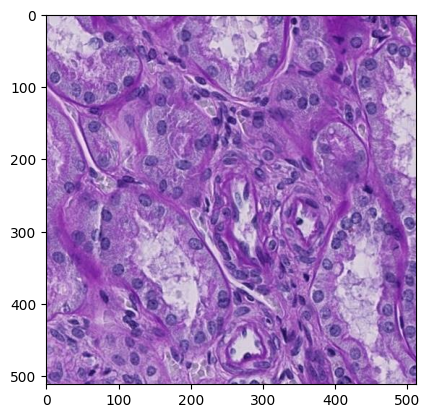

In [6]:
dirlist = os.listdir("/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/train/images/")
random_num = np.random.randint(0, len(dirlist))
image = Image.open("/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/train/images/"+ dirlist[random_num])
plt.imshow(image)
plt.show()

In [7]:
# install ultralytics version 8.0.131
!pip install ultralytics==8.0.131
display.clear_output()

In [8]:
pip show ultralytics

Name: ultralytics
Version: 8.0.131
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, opencv-python, pandas, Pillow, psutil, PyYAML, requests, scipy, seaborn, torch, torchvision, tqdm
Required-by: 


In [9]:
# install pycocotools version 2.0.6
!pip install pycocotools==2.0.6
display.clear_output()


In [10]:
pip show pycocotools


Name: pycocotools
Version: 2.0.6
Summary: Official APIs for the MS-COCO dataset
Home-page: https://github.com/ppwwyyxx/cocoapi
Author: 
Author-email: 
License: FreeBSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy
Required-by: 


In [11]:
from pycocotools import _mask as coco_mask
import ultralytics
from ultralytics import YOLO



In [12]:
ultralytics.checks()


Ultralytics YOLOv8.0.131 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 25.5 GB RAM, 24.3/166.8 GB disk)


In [13]:
!nvidia-smi

Sun Jul 23 22:36:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
def main():
    model = YOLO("yolov8x-seg.pt")
    model.train(
        # Project
        project="HuBMAP",
        name="yolov8x-seg",

        # Random Seed parameters
        deterministic=True,
        seed=43,

        # Data & model parameters
        data="/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/coco.yaml",
        save=True,
        save_period=5,
        pretrained=True,
        imgsz=512,

        # Training parameters
        epochs=60,
        batch=16,
        workers=8,
        val=True,
        device= 0,

        # Optimization parameters
        lr0=0.01,
        patience=10,
        optimizer="SGD",
        momentum=0.947,
        weight_decay=0.001,  # try 0.001 vs 0.1
        close_mosaic=3,
        dropout = 0.3
    )

In [15]:
if __name__ == '__main__':
    main()

100%|██████████| 137M/137M [00:03<00:00, 42.2MB/s]
New https://pypi.org/project/ultralytics/8.0.141 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.131 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=segment, mode=train, model=yolov8x-seg.pt, data=/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/coco.yaml, epochs=60, patience=10, batch=16, imgsz=512, save=True, save_period=5, cache=False, device=0, workers=8, project=HuBMAP, name=yolov8x-seg, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=3, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

In [16]:
files.download('/content/HuBMAP/yolov8x-seg/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import matplotlib.pyplot as plt
from PIL import Image

In [18]:
dirlist = os.listdir("/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/val/images")
print(dirlist[:5])

['da1c6d6657e9.tif', 'd9808586aef2.tif', 'da054a47370e.tif', 'da774b6f9cd1.tif', 'da2863316247.tif']



image 1/1 /gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/val/images/fbd64e93f84d.tif: 512x512 10 blood_vessels, 75.9ms
Speed: 1.9ms preprocess, 75.9ms inference, 12.8ms postprocess per image at shape (1, 3, 512, 512)


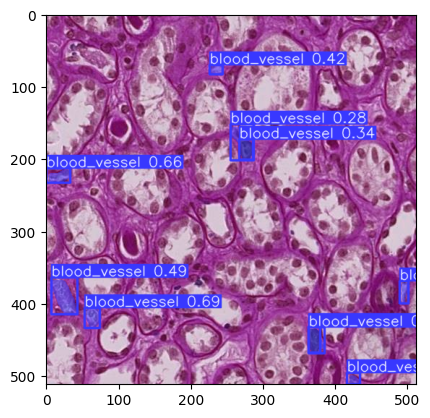

In [20]:
model = YOLO("/content/HuBMAP/yolov8x-seg/weights/best.pt")
history = model.predict("/gdrive/MyDrive/DATA/HuBMAP/coco_85train_dataset/dataset/val/images/fbd64e93f84d.tif")[0]
image = history.plot()
plt.imshow(image)
plt.show()

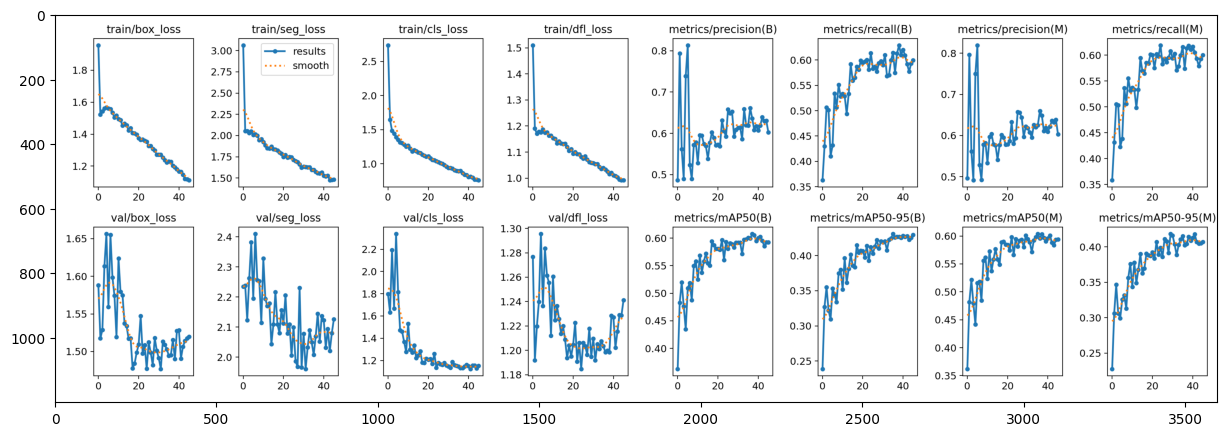

In [21]:
F1_curve = Image.open("/content/HuBMAP/yolov8x-seg/results.png")
plt.figure(figsize=(15,20))
plt.imshow(F1_curve)
plt.show()

In [22]:
results = pd.read_csv("/content/HuBMAP/yolov8x-seg/results.csv")
results.head()
results.to_csv('/gdrive/MyDrive/DATA/HuBMAP/Results/is_yolov8_v15_20230723.csv')

In [23]:
results

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.9556,3.0636,2.73720,1.50990,0.48642,0.36273,0.36281,0.23868,0.49596,0.35824,0.36199,0.22771,1.5879,2.2343,1.7976,1.2767,0.070345,0.003295,0.003295
1,1,1.5221,2.0547,1.64480,1.19020,0.79393,0.42968,0.48270,0.32713,0.79647,0.43118,0.48185,0.30622,1.5174,2.2378,1.6307,1.1919,0.040235,0.006519,0.006519
2,2,1.5428,2.0521,1.48330,1.17010,0.56175,0.50620,0.51987,0.35521,0.56135,0.50527,0.52142,0.34653,1.5288,2.1233,2.1933,1.2196,0.010016,0.009633,0.009633
3,3,1.5606,2.0306,1.44380,1.17800,0.49006,0.50122,0.47619,0.32208,0.49129,0.50307,0.47920,0.30615,1.6133,2.2625,1.6681,1.2399,0.009505,0.009505,0.009505
4,4,1.5662,2.0498,1.39050,1.17540,0.73902,0.40981,0.43489,0.30941,0.74958,0.42269,0.44192,0.29936,1.6563,2.3817,2.3387,1.2955,0.009505,0.009505,0.009505
5,5,1.5608,2.0080,1.35270,1.18680,0.81353,0.43151,0.50934,0.35314,0.81946,0.43829,0.51577,0.32575,1.5593,2.1954,1.8140,1.2365,0.009340,0.009340,0.009340
6,6,1.5564,2.0167,1.31430,1.17440,0.52320,0.53405,0.51877,0.34483,0.52858,0.53621,0.51810,0.33167,1.6549,2.4100,1.4721,1.2836,0.009175,0.009175,0.009175
7,7,1.5342,1.9989,1.30490,1.17580,0.48964,0.50618,0.48766,0.33371,0.49227,0.50603,0.48437,0.31295,1.5983,2.2567,1.4603,1.2614,0.009010,0.009010,0.009010
8,8,1.5037,1.9473,1.28100,1.16270,0.57204,0.55092,0.54945,0.37474,0.57780,0.55516,0.55585,0.35648,1.5741,2.2527,1.3669,1.2555,0.008845,0.008845,0.008845
9,9,1.5166,1.9578,1.25310,1.16300,0.57826,0.52800,0.55809,0.37972,0.58183,0.53155,0.56134,0.37611,1.5195,2.1147,1.2764,1.2121,0.008680,0.008680,0.008680


In [ ]:
plt.figure

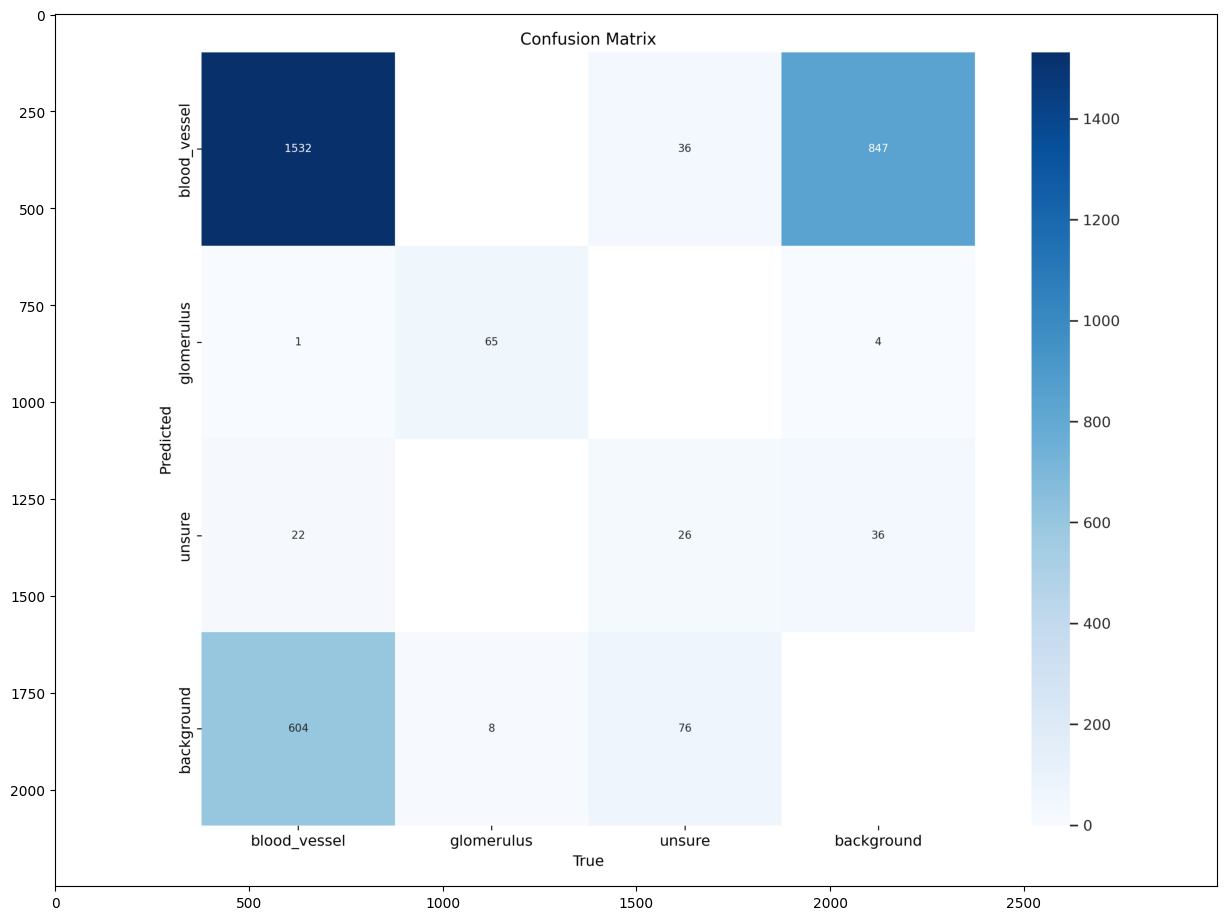

In [24]:
plt.figure(figsize=(15,20))
confusion_matrix = Image.open("/content/HuBMAP/yolov8x-seg/confusion_matrix.png")
plt.imshow(confusion_matrix)
plt.show()


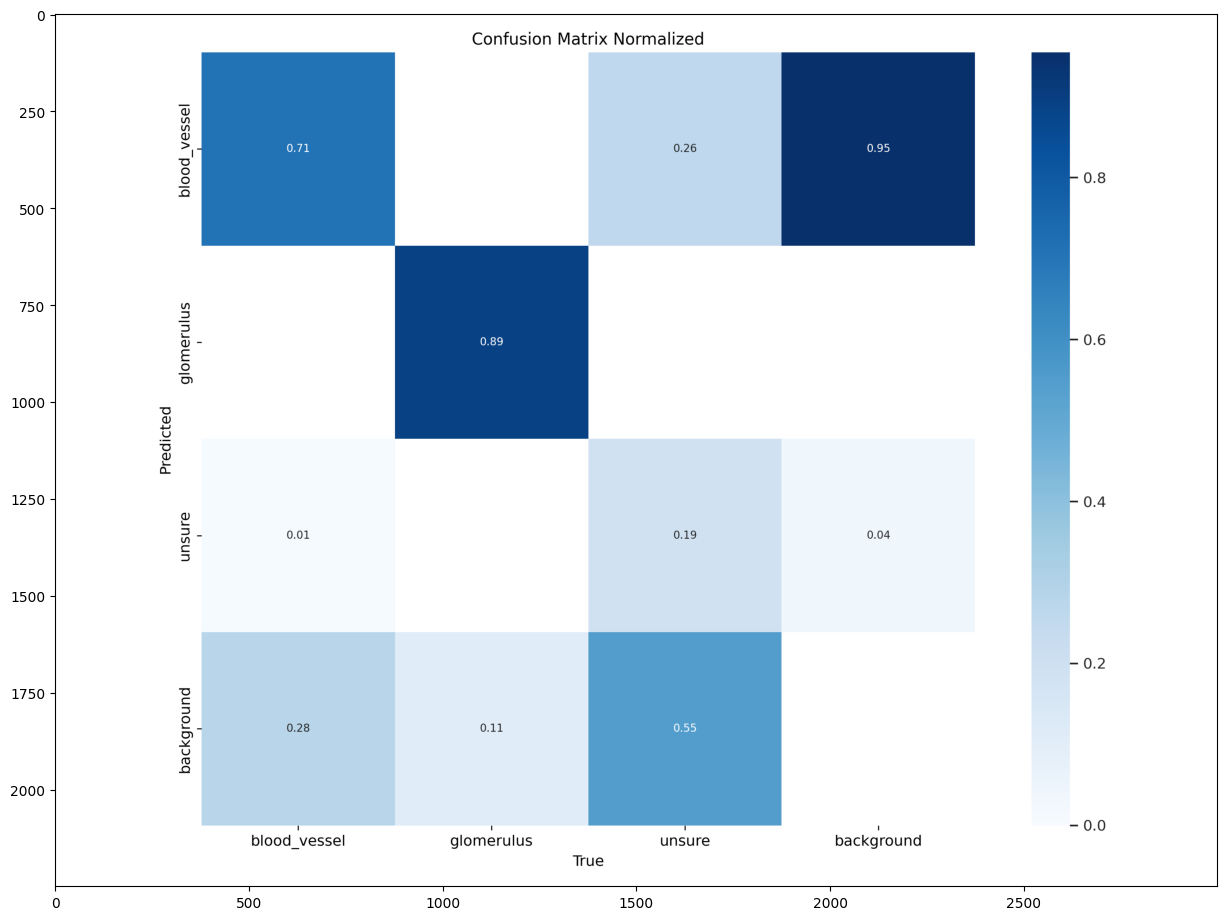

In [25]:
plt.figure(figsize=(15,20))
confusion_matrix = Image.open("/content/HuBMAP/yolov8x-seg/confusion_matrix_normalized.png")
plt.imshow(confusion_matrix)
plt.show()

In [26]:
results = pd.read_csv("/gdrive/MyDrive/DATA/HuBMAP/Results/is_yolov8_v15_20230723.csv",index_col=0)
results.columns = results.columns.str.strip()

results

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.9556,3.0636,2.73720,1.50990,0.48642,0.36273,0.36281,0.23868,0.49596,0.35824,0.36199,0.22771,1.5879,2.2343,1.7976,1.2767,0.070345,0.003295,0.003295
1,1,1.5221,2.0547,1.64480,1.19020,0.79393,0.42968,0.48270,0.32713,0.79647,0.43118,0.48185,0.30622,1.5174,2.2378,1.6307,1.1919,0.040235,0.006519,0.006519
2,2,1.5428,2.0521,1.48330,1.17010,0.56175,0.50620,0.51987,0.35521,0.56135,0.50527,0.52142,0.34653,1.5288,2.1233,2.1933,1.2196,0.010016,0.009633,0.009633
3,3,1.5606,2.0306,1.44380,1.17800,0.49006,0.50122,0.47619,0.32208,0.49129,0.50307,0.47920,0.30615,1.6133,2.2625,1.6681,1.2399,0.009505,0.009505,0.009505
4,4,1.5662,2.0498,1.39050,1.17540,0.73902,0.40981,0.43489,0.30941,0.74958,0.42269,0.44192,0.29936,1.6563,2.3817,2.3387,1.2955,0.009505,0.009505,0.009505
5,5,1.5608,2.0080,1.35270,1.18680,0.81353,0.43151,0.50934,0.35314,0.81946,0.43829,0.51577,0.32575,1.5593,2.1954,1.8140,1.2365,0.009340,0.009340,0.009340
6,6,1.5564,2.0167,1.31430,1.17440,0.52320,0.53405,0.51877,0.34483,0.52858,0.53621,0.51810,0.33167,1.6549,2.4100,1.4721,1.2836,0.009175,0.009175,0.009175
7,7,1.5342,1.9989,1.30490,1.17580,0.48964,0.50618,0.48766,0.33371,0.49227,0.50603,0.48437,0.31295,1.5983,2.2567,1.4603,1.2614,0.009010,0.009010,0.009010
8,8,1.5037,1.9473,1.28100,1.16270,0.57204,0.55092,0.54945,0.37474,0.57780,0.55516,0.55585,0.35648,1.5741,2.2527,1.3669,1.2555,0.008845,0.008845,0.008845
9,9,1.5166,1.9578,1.25310,1.16300,0.57826,0.52800,0.55809,0.37972,0.58183,0.53155,0.56134,0.37611,1.5195,2.1147,1.2764,1.2121,0.008680,0.008680,0.008680


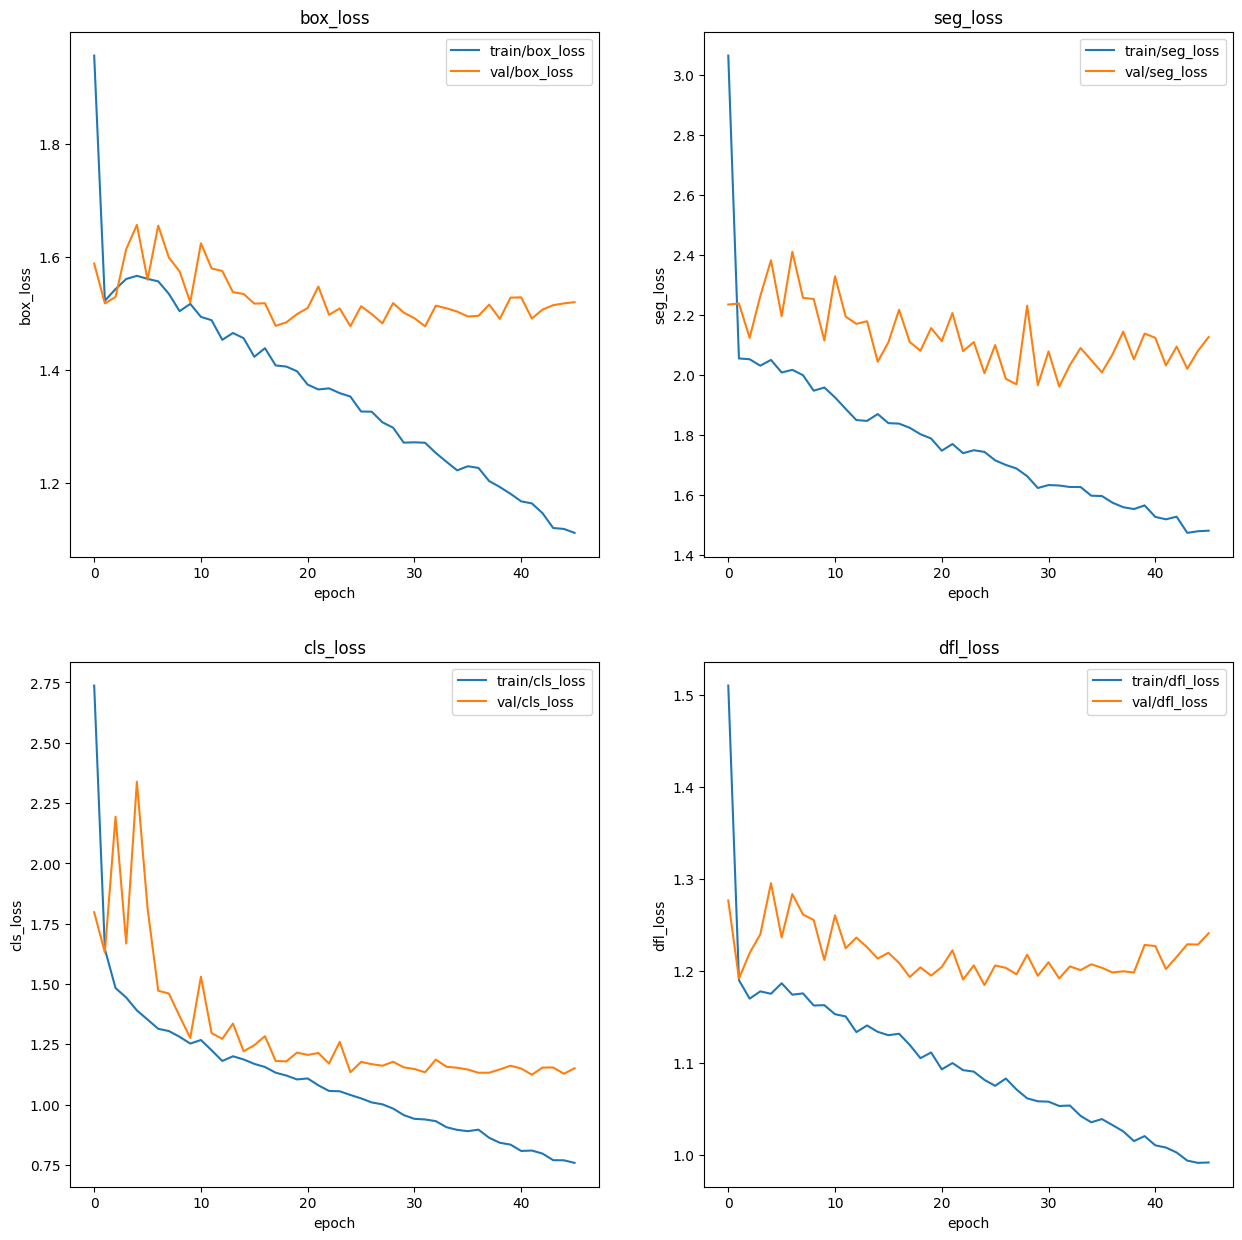

In [27]:
plt.figure(figsize=(15,15))

loss_labels = results.columns.tolist()[1:5] + results.columns.tolist()[13:17]
for idx in range(4):
  plt.subplot(2,2,idx+1)
  plt.plot(results['epoch'],results[loss_labels[idx]],label = loss_labels[idx])
  plt.plot(results['epoch'],results[loss_labels[idx+4]],label = loss_labels[idx+4])
  plt.legend(loc='upper right')
  plt.xlabel('epoch')
  plt.ylabel(loss_labels[idx].split('/')[1])
  plt.title(loss_labels[idx].split('/')[1])



plt.show();



In [ ]:
results

,epoch,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(M),metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.83960,2.9835,2.95750,1.7110,0.39327,0.37301,0.34542,0.23487,0.39835,0.37881,0.34549,0.22608,1.4892,2.1676,1.9566,1.4209,0.070345,0.003295,0.003295
1,1,1.48700,2.0922,1.79790,1.3536,0.46723,0.43623,0.47617,0.32255,0.47225,0.44287,0.48009,0.32075,1.5526,2.1286,1.8657,1.4212,0.040235,0.006519,0.006519
2,2,1.46880,2.0429,1.66010,1.3196,0.54113,0.48398,0.49766,0.33215,0.56203,0.49915,0.50358,0.32441,1.5084,2.0386,1.7819,1.3783,0.010016,0.009633,0.009633
3,3,1.51780,2.0686,1.50190,1.3379,0.82615,0.39186,0.49993,0.33978,0.83344,0.39695,0.50365,0.32216,1.5438,2.1625,1.7384,1.4301,0.009505,0.009505,0.009505
4,4,1.47910,2.0182,1.40940,1.3059,0.81398,0.43447,0.54065,0.37098,0.81836,0.43941,0.54712,0.36239,1.5074,2.0565,1.7436,1.3975,0.009505,0.009505,0.009505
5,5,1.46880,1.9982,1.34080,1.3209,0.76670,0.42149,0.50439,0.33624,0.77441,0.42784,0.51607,0.33067,1.6085,2.1443,1.6915,1.4949,0.009340,0.009340,0.009340
6,6,1.45770,1.9659,1.30730,1.3156,0.51755,0.56358,0.55657,0.38332,0.52580,0.57114,0.56468,0.37636,1.5212,2.1049,1.4713,1.4189,0.009175,0.009175,0.009175
7,7,1.46250,1.9742,1.31750,1.3175,0.58163,0.50600,0.54974,0.37791,0.59268,0.51227,0.55538,0.37158,1.5015,2.0918,1.3580,1.4079,0.009010,0.009010,0.009010
8,8,1.43160,1.9216,1.25500,1.3034,0.53174,0.60280,0.56820,0.39061,0.53604,0.60860,0.57690,0.38675,1.4945,2.0421,1.3382,1.4004,0.008845,0.008845,0.008845
9,9,1.43740,1.9240,1.24870,1.3054,0.53629,0.55604,0.54427,0.37485,0.54472,0.55708,0.54746,0.36985,1.5069,1.9763,1.3752,1.4061,0.008680,0.008680,0.008680
